* Выполняемое задание -- Задание 4 "Ансамбли"
* Студент: Шеверев Сергей Вячеславови, 22М-05ММ
* Все пункты обязательной части задания, и дополнительные пункты: (XGBoost, LightGBM и CatBoost,  Optuna)


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

### Dataset
Описание признаков:
- Unnamed 0 -- Порядковый номер записи в датасете
- id -- уникальный идентификатор пассажира
- Customer Type -- уровень лояльности пассажира
- Age -- возраст пассажира 
- Type of Travel -- назначение перелета
- Class -- класс билета пасажира 
- Flight Distance -- расстояние перелета
- Inflight wifi service -- уровень удовлетворенности пассажира качеством wifi-сигнала на борту судна
- Departure/Arrival time convinient -- уровень удобности времени взлета и приземления
- Ease of Online booking -- уровень удовлетворенности сервиса онлайн бронирования билетов 
- Gate location -- уровень удобности расположения выхода на посадку
- Food and drink -- уровень удовлетворенности пасажира едой и напитками в салоне
- Online boarding -- уровень удовлетворенности пасажира сервисом регистрации на рейс
- Seat comfort -- уровень удовлетворенности пасажира удобности кресла
- Inflight entertainment -- уровень удовлетворенности пасажира развлечениями на борту
- On-board service -- уровень удовлетворенности пасажира обслуживанием на борту
- Leg room service --  уровень удовлетворенности пасажира свободным местом для ног
- Baggage handling -- уровень удовлетворенности пасажира обработкой багажа
- Check-in service -- уровень удовлетворенности пасажира процессом регистрации
- Inflight service -- уровень удовлетворенности пасажира качеством обслуживания в полете
- Cleanliness -- уровень удовлетворенности пасажира чистотой на борту
- Departure Delay in Minutes -- задержка вылета рейса в минутах
- Arrival Delay in Minutes -- задержка прибытия в минутах
- Satisfaction -- **целевой признак** общей лояльности клиента

Загрузим датасет: 

In [50]:
df = pd.read_csv('test.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


Проверим, удовлетворяет ли данный датасет критерию на количество записей:

In [51]:
print(df.count()[0] > 10000)
print(f"Всего записей в датасете: {df.count()[0]}")

True
Всего записей в датасете: 25976


Видно, что первая колонка -- это просто номер записи в датасете, она не несет никакой информации, как и поле **id**. Удалим их.

In [52]:
df.drop(columns = list(df.columns)[:2], inplace=True)

Проверим датасет на наличие незаполненных полей:

In [53]:
df.isnull().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

Поле **Arrival Delay in Minutes** имеет незаполненные значения. Таких значений крайне мало. Удалим их в таком случае:

In [63]:
df.drop(df[df["Arrival Delay in Minutes"].isnull()].index, inplace = True)

Объединим признаки **Departure Delay in Minutes** и **Arrival Delay in Minutes**, посчитаем их сумму: 

In [70]:
df["Delay in Minutes"] =  df["Departure Delay in Minutes"] + df["Arrival Delay in Minutes"]
df.drop(["Departure Delay in Minutes", "Arrival Delay in Minutes"], axis=1, inplace=True)

In [71]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Delay in Minutes
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,3,5,5,5,5,2,5,5,satisfied,94.0
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,5,4,4,4,4,3,4,5,satisfied,0.0
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,2,4,1,3,2,2,2,neutral or dissatisfied,0.0
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,4,1,1,1,1,3,1,4,satisfied,6.0
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,2,4,2,4,satisfied,20.0


Какие значения принимает целевой признак?

In [81]:
df['satisfaction'].unique()

array(['satisfied', 'neutral or dissatisfied'], dtype=object)

Кажется, что целевой признак -- бинарный:

In [82]:
df["satisfaction"] = df["satisfaction"].apply(lambda x: 1 if x == "satisfied" else 0)

Посмотрим на корреляцию числовых признаков:

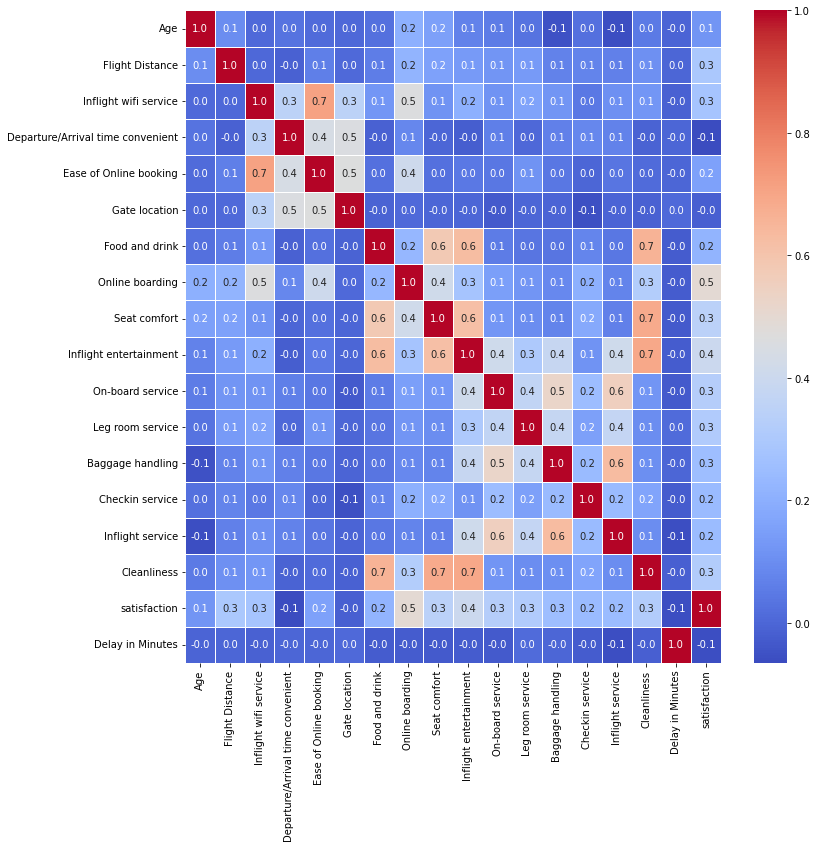

In [86]:
numeric_features = ['Age','Flight Distance',
                    'Inflight wifi service',
                    'Departure/Arrival time convenient',
                    'Ease of Online booking',
                    'Gate location', 
                    'Food and drink', 
                    'Online boarding',
                    'Seat comfort',
                    'Inflight entertainment',
                    'On-board service',
                    'Leg room service',
                    'Baggage handling',
                    'Checkin service',
                    'Inflight service',
                    'Cleanliness',
                    'Delay in Minutes',
                    'satisfaction']
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr()[numeric_features], annot=True, fmt='.1f', linewidths=.5, cmap='coolwarm')
plt.show()

Видно, что малое количество признаков сильно коррелируют. Можно выделить следующие:
- **Inflight wifi service** коррелирует с **Online boarding** и с **Ease of Online booking**
- **Departure/Arrival time convenient** коррелирует с **Gate Location** и с **Ease of online booking**
- **Food and Drink** коррелирует с **Seat comfort**, **Inflight entertainment**, **Clearness**
- **Online boarding** коррелирует с **Seat comfort** и с целевым признаком  **satisfaction**
- **Inflight entertainment** коррелирует с **On-board service**, **Baggage handling**, **Inflight service**, целевым признаком **satisfaction**
- **On-board service** коррелирует с **Leg room service**
- **Leg room service** коррелирует с **Inflight service**

In [92]:
cat_features = list(df.columns)
for i in numeric_features:
    cat_features.remove(i)
df[cat_features]

,Gender,Customer Type,Type of Travel,Class
0,Female,Loyal Customer,Business travel,Eco
1,Female,Loyal Customer,Business travel,Business
2,Male,disloyal Customer,Business travel,Eco
3,Male,Loyal Customer,Business travel,Business
4,Female,Loyal Customer,Business travel,Eco
...,...,...,...,...
25971,Male,disloyal Customer,Business travel,Business
25972,Male,Loyal Customer,Business travel,Business
25973,Female,Loyal Customer,Personal Travel,Eco
25974,Male,Loyal Customer,Business travel,Business


Признак **Gender**:

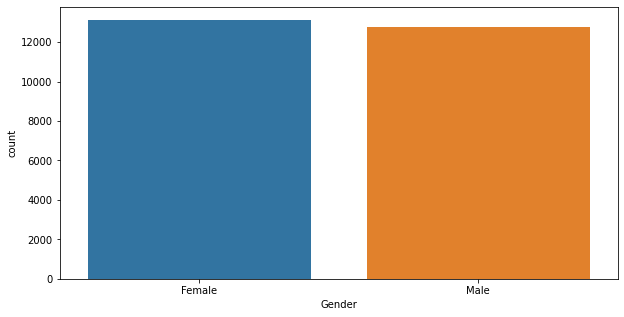

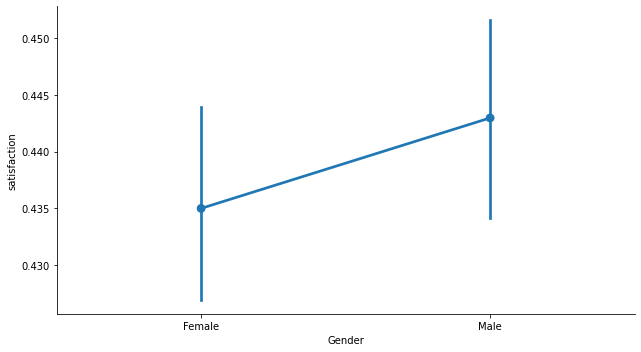

In [103]:
sns.countplot(data=df, x="Gender")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()
sns.catplot(data=df, x="Gender", y="satisfaction", kind="point")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Видно, что  женщин и мужчин примерно одинаковое количество. Однако степень удовлетворенности полетом среди мужчин незначительно выше, чем у женщин.

Признак **Customer Type**:


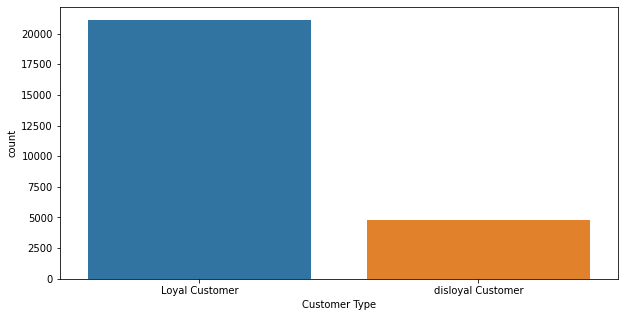

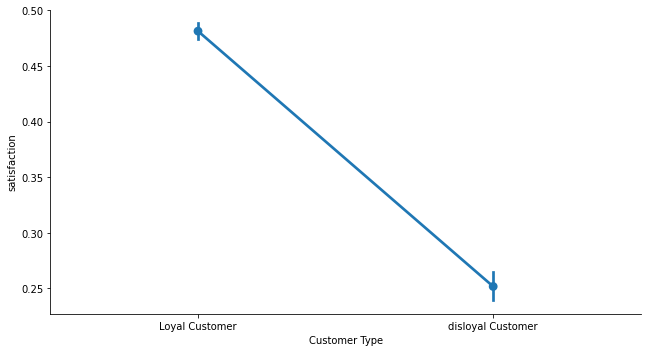

In [107]:
sns.countplot(data=df, x="Customer Type")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()
sns.catplot(data=df, x="Customer Type", y="satisfaction", kind="point")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Лояльных клиентов значительно больше, среди нелояльных высока вероятность того, что они не удовлетворены полетом.

Признак **Type of Travel**:

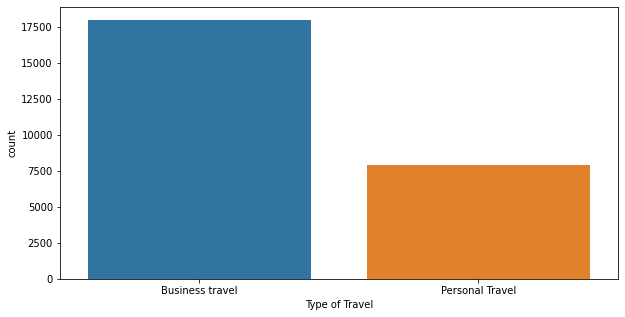

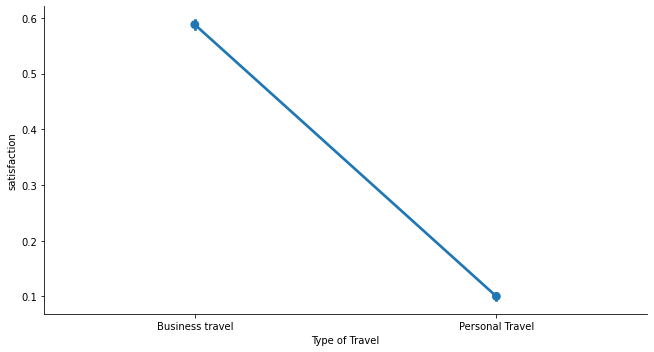

In [108]:
sns.countplot(data=df, x="Type of Travel")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()
sns.catplot(data=df, x="Type of Travel", y="satisfaction", kind="point")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

В данном датасете в основном содержатся данные о деловых перелетах. Можно сказать, что люди, летающие в личных целях, обычно более недовольные полетом.

Признак **Class**:

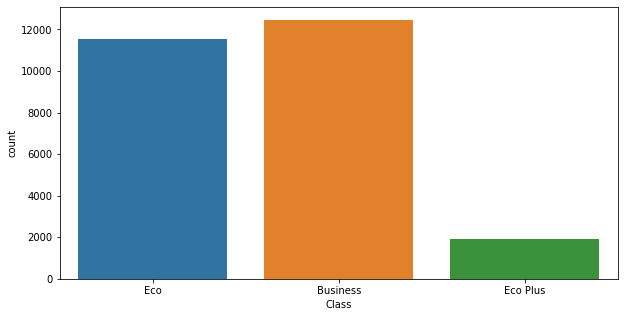

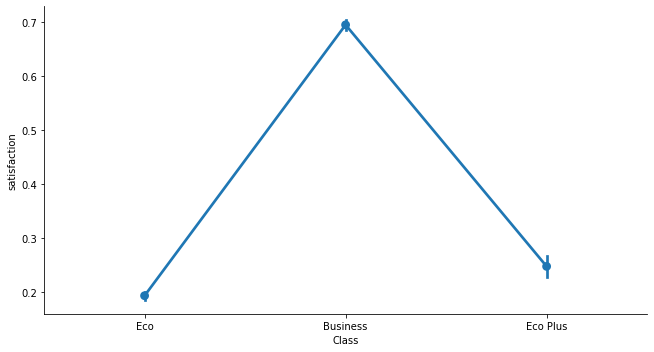

In [109]:
sns.countplot(data=df, x="Class")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()
sns.catplot(data=df, x="Class", y="satisfaction", kind="point")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Люди выбирают либо эконом-класс, либо Бизнесс-класс, малое количество пользуется промежуточным вариантом. Возникает ощущие, что экономичность билета сильно влияет на удовлетворенность пасажиров: чем дороже билет, тем более удовлетворен пасажир.

Выполним некоторые дополнительные преобразования над данными:

In [113]:
df["Gender"] = df["Gender"].apply(lambda x: 0 if x == "Female" else 1)
df["Customer Type"]  = df["Customer Type"].apply(lambda x: 1 if x == "Loyal Customer" else 1)
df["Type of Travel"] = df["Type of Travel"].apply(lambda x: 1 if x == "Business travel" else 0)
df["Class"] = df["Class"].apply(lambda x: 0 if x == "Eco" else 1 if x == "Eco Plus" else 2)

В том числе *One-hot encoding* для признака **Class**:


In [116]:
df = pd.get_dummies(df, prefix=["Class"], columns=["Class"])

В результате получим: 

In [118]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Delay in Minutes,Class_0,Class_1,Class_2
0,0,1,52,1,160,5,4,3,4,3,...,5,5,2,5,5,1,94.0,1,0,0
1,0,1,36,1,2863,1,1,3,1,5,...,4,4,3,4,5,1,0.0,0,0,1
2,1,1,20,1,192,2,0,2,4,2,...,1,3,2,2,2,0,0.0,1,0,0
3,1,1,44,1,3377,0,0,0,2,3,...,1,1,3,1,4,1,6.0,0,0,1
4,0,1,49,1,1182,2,3,4,3,4,...,2,2,4,2,4,1,20.0,1,0,0


In [119]:
from sklearn.model_selection import train_test_split
y = df["satisfaction"]
features = list(df.keys())
features.remove("satisfaction")
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

from sklearn.preprocessing import StandardScaler

numeric_features = ['Age','Flight Distance',
                    'Inflight wifi service',
                    'Departure/Arrival time convenient',
                    'Ease of Online booking',
                    'Gate location', 
                    'Food and drink', 
                    'Online boarding',
                    'Seat comfort',
                    'Inflight entertainment',
                    'On-board service',
                    'Leg room service',
                    'Baggage handling',
                    'Checkin service',
                    'Inflight service',
                    'Cleanliness',
                    'Delay in Minutes']
binary_features = features;
for i in numeric_features:
    binary_features.remove(i)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# масштабируем тестовую выборку
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train = np.c_[X_train_scaled, np.array(X_train[binary_features])]
X_test = np.c_[X_test_scaled, np.array(X_test[binary_features])]

### Реализация Bagging: 

In [234]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import accuracy_score

class MyBagger():
    def __init__(self, estimator = DecisionTreeClassifier(), n_estimators: int = 10, max_samples: float = 1.0, max_features: float = 1.0, n_jobs=-1):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.n_jobs = n_jobs
        
        self.estimators = []
        self.estimators_features = []
    def fit(self, X, y):
        def get_random_cols(X, y):
            features_num = min(int(np.round(self.max_features * X.shape[1])), X.shape[1])
            return np.random.choice(X.shape[1], features_num, replace=False) 
        def get_random_rows(X, y, features):
            samples_num = min(int(np.round(self.max_samples * X.shape[0])), X.shape[0])
            return resample(X[:,features], y, replace=True, n_samples=samples_num, random_state=5)                       
            
        for i in range(self.n_estimators):
                features = get_random_cols(X, y)
                X_, y_ = get_random_rows(X, y, features)
                self.estimators.append(self.estimator.fit(X_, y_))
                self.estimators_features.append(features)
    
    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        for estimator, features in zip(self.estimators, self.estimators_features):
            prediction += estimator.predict(X[:,features])
        return np.array(np.round(prediction/len(self.estimators)), dtype="int64")

        

### Реализация AdaBoost:

In [208]:
class MyAdaBooster():
    def __init__(self, estimator = DecisionTreeClassifier(), n_estimators: int = 10):
        self.estimator = estimator
        self.n_estimators = n_estimators
        
        self.estimators_weights = []
        self.estimators = []
        
    def fit(self, X, y):
        initial_weight = 1/X.shape[0]
        data_weights = np.array([initial_weight for i in range(X.shape[0])])
        
        def get_error(ys, predictions, data_weights):
            res = 0
            for y, p, w in zip(ys, predictions, data_weights):
                res += w if y != p else 0
            return res

            
        for i in range(self.n_estimators):
            estim = self.estimator.fit(X, y, sample_weight=data_weights)
            prediction = estim.predict(X)
            error = get_error(y, prediction, data_weights)
            
            self.estimators_weights.append( 1 if error <= 0 else np.log((1 - error)/error))
            
            data_weights *= np.exp(self.estimators_weights[-1] * (y != prediction) * ((data_weights > 0) |(self.estimators_weights[-1] < 0)))
            data_weights /= np.sum(data_weights)
            
            self.estimators.append(estim)
            
    def predict(self, X):
        prediction = 0
        for estimator, weight in zip(self.estimators, self.estimators_weights):
            prediction += weight*estimator.predict(X)
        return np.sign(prediction)
            
            
            

### Обучение моделей:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier,  BaggingClassifier
import optuna
import time

trials_num = 300
models = [MyBagger(), MyAdaBooster(), BaggingClassifier(), AdaBoostClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), HistGradientBoostingClassifier(), XGBClassifier(), LGBMClassifier(), CatBoostClassifier()]
models_name = ["MyBagger","MyAdaBooster","BaggingClassifier","AdaBoostClassifier","RandomForestClassifier","GradientBoostingClassifier", "HistGradientBoostingClassifier", "XGBClassifier", "LGBMClassifier","CatBoostClassifier" ]
params = [{"n_estimators":(1, 100), "max_samples": (0.10, 1.0), "max_features": (0.1, 1.0)},
          {"n_estimators":(1,100)},
          {"n_estimators":(1, 100), "max_samples": (0.1, 1.0), "max_features": (0.1, 1.0)},
          {"n_estimators":(1,100)},
          {"n_estimators":(1,100), "max_depth":(4,16), "max_samples":(0.10,1.00), "max_features":(0.10,1.00)},
          {"n_estimators":(1,100), "max_depth":(4,16), "max_features":(0.10,1.00)},
          {"max_depth":(4, 16), "max_iter":(30, 150)},
          {"n_estimators": (1, 100), "max_depth":(4, 16)},
          {"n_estimators":(1, 100), "max_depth":(4, 16)},
          {"n_estimators": (1, 100), "max_depth":(4, 16)}
         ]
results = {"Models": models_name, 
           "Accuracy": [],
           "Time": [], 
           "Best Params":[]
          }
optuna.logging.set_verbosity(optuna.logging.WARNING)

for i in range(len(models)):
    def objective(trial):
        res_param = {}
        keys = list(params[i].keys())
        for key in keys:
            tmp = None
            if (key == "max_samples" or key == "max_features"):
                tmp = trial.suggest_float(key,params[i][key][0], params[i][key][1])
            else: 
                tmp = trial.suggest_int(key,params[i][key][0], params[i][key][1])
            res_param[key] = tmp
        
        if (models_name[i] == "CatBoostClassifier"):
            res_param["verbose"] = False
        learner = type(models[i])(**res_param)
        learner.fit(X_train, y_train)
        prediction = learner.predict(X_test)
        return accuracy_score(y_test, prediction)
    start_time = time.time()
    optuna_study = optuna.create_study(direction="maximize")
    optuna_study.optimize(objective, n_trials=trials_num)
    stop_time = time.time()
    results["Time"].append((stop_time - start_time)/trials_num)
    results["Accuracy"].append(optuna_study.best_value)
    results["Best Params"].append(optuna_study.best_params)
    
    
    
    
            
        


### Результаты обучения:

In [ ]:
pd.DataFrame(data = results).sort_values(by="Accuracy", ascending=False).drop("Best Params", axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(20, 10))

for i in range(len(models)):
    if (models_name[i] == "CatBoostClassifier"):
        results["Best Params"][i]["verbose"] = False
    tmp = type(models[i])(**results["Best Params"][i])
    tmp.fit(X_train, y_train)
    prediction = tmp.predict(X_test)
    plt.subplot(2, 5, i+1)
    plt.title(models_name[i])
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True,cbar=True, fmt='d', annot_kws={"size": 18})

plt.show()